<a href="https://colab.research.google.com/github/HedyehNazari/Brain-Activity-Prediction/blob/main/Convnet_For_Brain_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
from google.colab import drive


In [ ]:
## Colab setting
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/
#%mkdir -p Neuromatch
%cd Neuromatch/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/'
/content/gdrive/MyDrive/Neuromatch
[Errno 2] No such file or directory: 'Neuromatch/'
/content/gdrive/MyDrive/Neuromatch


In [ ]:
## Download the dataset
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download


In [ ]:
## Load the data
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

##configuration


In [ ]:
config={
    'DEVICE' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'TRAIN_SIZE' : 1400,
    'epoch' : 100,
    'BATCH_SIZE': 16,
    'CHECKPOINT': 'checkpoint',
    'LOAD_FROM_FILE': True,

}



In [ ]:
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [ ]:
SEED = 2021
set_seed(seed=SEED)


Random seed 2021 has been set.


## Utility Functions

In [ ]:
def count_errors(y_prediction, y_true, std=1):
  return torch.sum(torch.abs(y_prediction - y_true) > std).item()
  

In [ ]:
def correlation(x, y):
  vx = x - torch.mean(x)
  vy = y - torch.mean(y)
  return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))

In [ ]:
## Function to save a model and its optimizer to drive
def save(name: str, model: nn.Module, optimizer: optim.Optimizer, epoch: int):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, name)

In [ ]:
## Function to load a model and its optimizer from drive
def load(name: str, model: nn.Module, optimizer: optim.Optimizer):
    checkpoint = torch.load(name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.train()

In [ ]:
def l1_reg(model):
  l1 = 0.0
  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))
  return l1


In [ ]:
def l2_reg(model):
  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)
  return l2

In [ ]:
def roi_voxels(dat):
  v1,v2,v3,v3A,v3B,LatOcc,v4 = [],[],[],[],[],[],[]
  for voxel in range(8428):
    if dat['roi'][voxel]==1:
      v1.append(voxel) 
    elif dat['roi'][voxel]==2:
      v2.append(voxel)
    elif dat['roi'][voxel]==3:
      v3.append(voxel)
    elif dat['roi'][voxel]==4:
      v3A.append(voxel)
    elif dat['roi'][voxel]==5:
      v3B.append(voxel)
    elif dat['roi'][voxel]==6:
      v4.append(voxel)
    elif dat['roi'][voxel]==7:
      LatOcc.append(voxel)
  voc = np.array([v1,v2,v3,v3A,v3B,LatOcc,v4])
  return voc

def mean_roi(dat,voc):
  v1_mean = np.mean(dat['responses'][:,voc[0]],axis=1)
  v2_mean = np.mean(dat['responses'][:,voc[1]],axis=1)
  v3_mean = np.mean(dat['responses'][:,voc[2]],axis=1)
  v3A_mean = np.mean(dat['responses'][:,voc[3]],axis=1)
  v3B_mean = np.mean(dat['responses'][:,voc[4]],axis=1)
  v4_mean = np.mean(dat['responses'][:,voc[5]],axis=1)
  LatOcc_mean = np.mean(dat['responses'][:,voc[6]],axis=1)
  response = np.transpose(np.array([v1_mean,v2_mean,v3_mean,v3A_mean,v3B_mean,v4_mean,LatOcc_mean]))
  return response

##Data

In [ ]:
class ImageSignalDataset(Dataset):
  def __init__(self, images, signals, image_transform=None, signal_transform=None):
    '''
      images is a n * 128 * 128 numpy array
      signals is a n * 8428 numpy array
    '''
    self.images = images
    self.signals = signals
    self.image_transform = image_transform
    self.signal_transform = signal_transform
    assert images.shape[0] == signals.shape[0]

  def __len__(self):
    return self.images.shape[0]

  ## TODO: signal_transform not working
  def __getitem__(self, index):
    x = self.image_transform(self.images[index, :, :]) if self.image_transform else self.images[index, :, :]
    y = torch.tensor(self.signals[index, :])
    # y = self.signal_transform(self.signals[index, :]) if self.signal_transform else self.signals[index, :]
    return x, y
# print(dat["stimuli"].shape)
# print(dat["responses"].shape)
#d = ImageSignalDataset(dat["stimuli"],dat["responses"],image_transform=ToTensor())
# x,y = d[50]
# print(x.shape)
# print(y.shape)

In [ ]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [ ]:
trainset = ImageSignalDataset(dat['stimuli'][:config['TRAIN_SIZE'], :, :], dat['responses'][:config['TRAIN_SIZE'], :], image_transform = ToTensor(), signal_transform = ToTensor())
validationset = ImageSignalDataset(dat['stimuli'][config['TRAIN_SIZE']:, :, :], dat['responses'][config['TRAIN_SIZE']:, :], image_transform = ToTensor(), signal_transform = ToTensor())
testset = ImageSignalDataset(dat['stimuli_test'], dat['responses_test'], image_transform = ToTensor(), signal_transform = ToTensor())

train_loader = DataLoader(trainset, config['BATCH_SIZE'], shuffle=True)
validation_loader = DataLoader(validationset, config['BATCH_SIZE'], shuffle=False)
test_loader = DataLoader(testset, config['BATCH_SIZE'], shuffle=False)


print(f'trainset contains: {len(trainset)} pairs of image/signals')
print(f'valset   contains: {len(validationset)}  pairs of image/signals')
print(f'testset  contains: {len(testset)}  pairs of image/signals')


trainset contains: 1400 pairs of image/signals
valset   contains: 350  pairs of image/signals
testset  contains: 120  pairs of image/signals


##CNN model

In [ ]:
class Convnet(nn.Module):
   def __init__(self):
     super().__init__()
     self.conv1 = nn.Conv2d(in_channels=1,out_channels=4, kernel_size=8, stride=2, padding = 0) #4*61*61
     self.conv2 = nn.Conv2d(in_channels=4,out_channels=8, kernel_size=8, stride=2, padding = 0) #8*27*27
     self.conv3 = nn.Conv2d(in_channels=8,out_channels=16, kernel_size=8, stride=2, padding = 0) #16*10*10
     self.bn1  = nn.BatchNorm2d(4)
     self.bn2  = nn.BatchNorm2d(8)
     self.bn3  = nn.BatchNorm2d(16)
     self.drp  = nn.Dropout2d(0.5)    
     self.fc1 = nn.Linear(16*10*10,4000)
     #self.bn1d  = nn.BatchNorm1d(4000)
     self.fc2 = nn.Linear(4000,8428)
   def forward(self,x):
      x =  self.conv1(x) 
      x = nn.functional.relu(x)
      x =  self.bn1(x)
      x = self.drp(x)
      #print(x.shape)
      x =  self.conv2(x)
      x = nn.functional.relu(x)
      x = self.bn2(x)
      x = self.drp(x)
      #print(x.shape)
      x =  self.conv3(x) 
      x = nn.functional.relu(x)
      x = self.bn3(x)
      #print(x.shape)
      x = torch.flatten(x,1)
      x = self.fc1(x)
      #print(x.shape)
      #x =  self.bn1d(x)
      x = nn.functional.relu(x)
      x = self.fc2(x)
      return x
# model = Convnet().to(DEVICE)

# for batch in train_loader:
#   x,y = batch
#   x = x.to(DEVICE)
#   y = y.to(DEVICE)
#   z = c(x)
#   print("x shape",x.shape)
#   print("z shape",z.shape)
#   break

## Trainingloop

In [ ]:
model = Convnet().to(config['DEVICE'])
optimizer = optim.Adam(model.parameters(), lr = 0.0001) 
loss_fn = nn.MSELoss()

In [ ]:
# Load model and optimizer from drive
if config['LOAD_FROM_FILE']:
  load('checkpoint30.pt', model, optimizer)
  print('Model loaded!')

Model loaded!


In [ ]:

train_losses, val_losses, val_mistake, train_mistake,val_mistake_correlation,train_mistake_correlation  = [],[],[],[],[],[]
for epoch in range(config['epoch']):
  train_loss_sum = 0
  val_loss_sum = 0
  val_errors = 0
  total_e1 = 0.0
  total_e2 = 0.0

  model.train()
  for batch in train_loader:
    x,y = batch
    x = x.to(config['DEVICE'])
    y = y.float()
    y = y.to(config['DEVICE'])
    optimizer.zero_grad()
    z = model(x)
    
    outputloss = loss_fn(z, y)
    #outputloss += 0.0005 * l1_reg(model)
    outputloss += 0.0005* l2_reg(model)
    outputloss.backward()
    optimizer.step()
    train_loss_sum += outputloss.detach().item()
    total_e1 += count_errors(z.detach(), y.detach())
    total_e2 += correlation(z.detach(), y.detach())
    
  model.eval()
  with torch.no_grad():
    totalerror1 = 0
    totalerror2 = 0
    for batch in validation_loader:
      x,y = batch
      x = x.to(config['DEVICE'])
      y = y.float()
      y = y.to(config['DEVICE'])
      z = model(x)
      outputloss = loss_fn(z, y)
      
      val_loss_sum += outputloss.detach().item()
      totalerror1 += count_errors(z.detach(), y.detach())
      totalerror2 += correlation(z.detach(), y.detach())


  train_losses.append(train_loss_sum )
  val_losses.append(val_loss_sum )
  print(f'Epoch {epoch}: Loss = {train_loss_sum}')

  #counterror calculation
  val_mistake.append(totalerror1 / len(validationset))
  train_mistake.append(total_e1 / len(trainset))

  #correlation calculation
  val_mistake_correlation.append(totalerror2 / len(validationset))
  train_mistake_correlation.append(total_e2 / len(trainset))
 

  #every 10 epochs, save the model
  if epoch % 10 == 0:
    save(config['CHECKPOINT'] + f'{epoch}.pt', model, optimizer, epoch)
    print('Model saved!')

In [ ]:
print("train_losses:",train_losses)
print("val_losses:  ",val_losses)
print(min(val_losses), np.argmin(val_losses))
print("val_mistake:     ",val_mistake)
print("train_mistake:   ",train_mistake)
print("train_mistake_correlation:     ",train_mistake_correlation)
print("val_mistake_correlation:   ",val_mistake_correlation)

NameError: ignored

In [ ]:

plt.plot(np.arange(len(train_losses)), train_losses, 'r')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.savefig("Train Loss", dpi=300, format='JPEG')
plt.show()

plt.plot(np.arange(len(val_losses)), val_losses, 'b')
plt.xlabel('Epoch')
plt.savefig("Val Loss", dpi=300, format='JPEG')
plt.ylabel('Val Loss')
plt.show()

plt.plot(np.arange(len(train_mistake)), train_mistake, 'r')
plt.xlabel('Epoch')
plt.ylabel('Train Mistake')
plt.savefig("Train Mistake", dpi=300, format='JPEG')
plt.show()

plt.plot(np.arange(len(val_mistake)), val_mistake, 'b')
plt.xlabel('Epoch')
plt.ylabel('Val Mistake')
plt.savefig("Val Mistake", dpi=300, format='JPEG')
plt.show()

plt.plot(np.arange(len(train_mistake_correlation)), train_mistake_correlation, 'r')
plt.xlabel('Epoch')
plt.ylabel('Train Mistake Correlation')
plt.savefig("Train Mistake Correlation", dpi=300, format='JPEG')
plt.show()

plt.plot(np.arange(len(val_mistake_correlation)), val_mistake_correlation, 'b')
plt.xlabel('Epoch')
plt.ylabel('Val Mistake Correlation')
plt.savefig("Val Mistake Correlation", dpi=300, format='JPEG')
plt.show()





NameError: ignored

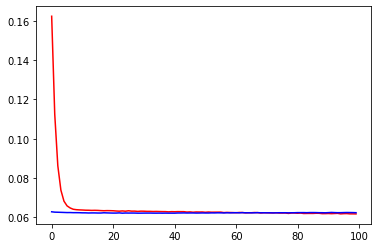

In [ ]:
plt.plot(np.arange(len(train_losses)), np.array(train_losses)/len(trainset), 'r')
plt.plot(np.arange(len(val_losses)), np.array(val_losses)/len(validationset), 'b')
plt.show()

In [ ]:
# evaluation 1
# batch_normalization 1
# dropout  befor or after relu 0
# ploting
#hyperparameters
#correlation

In [ ]:
model.eval()
with torch.no_grad():
  total, V1_total_val_mistakes, V2_total_val_mistakes, V3_total_val_mistakes, V4_total_val_mistakes, V7_total_val_mistakes = 0, 0, 0, 0, 0, 0
  for images, labels in validation_loader:
    images = images.to(config['DEVICE'])
    labels = labels.to(config['DEVICE']).float()
    # images = ae_model.enc5(ae_model.enc4(ae_model.enc3(ae_model.enc2(ae_model.enc1(images)))))
    # features = torch.flatten(images, 1).detach()

    predictions = model(images)

    v1_predictions = predictions [:, dat['roi'] == 1]
    v1_labels = labels [:, dat['roi'] == 1]

    v2_predictions = predictions [:, dat['roi'] == 2]
    v2_labels = labels [:, dat['roi'] == 2]

    v3_predictions = predictions [:, dat['roi'] == 3]
    v3_labels = labels [:, dat['roi'] == 3]

    v4_predictions = predictions [:, dat['roi'] == 6]
    v4_labels = labels [:, dat['roi'] == 6]

    v7_predictions = predictions [:, dat['roi'] == 7]
    v7_labels = labels [:, dat['roi'] == 7]

    # print(v1_labels.shape, v2_labels.shape, v3_labels.shape, v4_labels.shape)
    # break
    
    V1_total_val_mistakes += count_errors(v1_labels, v1_predictions)
    V2_total_val_mistakes += count_errors(v2_labels, v2_predictions)
    V3_total_val_mistakes += count_errors(v3_labels, v3_predictions)
    V4_total_val_mistakes += count_errors(v4_labels, v4_predictions)
    V7_total_val_mistakes += count_errors(v7_labels, v7_predictions)
    total += count_errors(labels, predictions)

print(f'V1 prediction accuracy is {1 - (V1_total_val_mistakes/ len(validationset) / 1294)}')
print(f'V2 prediction accuracy is {1 - (V2_total_val_mistakes/ len(validationset) / 2083)}')
print(f'V3 prediction accuracy is {1 - (V3_total_val_mistakes/ len(validationset) / 1790)}')
print(f'V4 prediction accuracy is {1 - (V4_total_val_mistakes/ len(validationset) / 1535)}')
print(f'V7 prediction accuracy is {1 - (V7_total_val_mistakes/ len(validationset) / 928)}')
print(f'Total prediction accuracy is {1 - (total/ len(validationset) / 8428)}')

V1 prediction accuracy is 0.6901192316184588
V2 prediction accuracy is 0.6911514985254783
V3 prediction accuracy is 0.6894924181963288
V4 prediction accuracy is 0.6876240111679851
V7 prediction accuracy is 0.6860283251231527
Total prediction accuracy is 0.689140958709065


In [ ]:
model.eval()
with torch.no_grad():
  total, V1_total_val_mistakes, V2_total_val_mistakes, V3_total_val_mistakes, V4_total_val_mistakes, V7_total_val_mistakes = 0, 0, 0, 0, 0, 0
  for images, labels in test_loader:
    images = images.to(config['DEVICE'])
    labels = labels.to(config['DEVICE']).float()
    # images = ae_model.enc5(ae_model.enc4(ae_model.enc3(ae_model.enc2(ae_model.enc1(images)))))
    # features = torch.flatten(images, 1).detach()

    predictions = model(images)

    v1_predictions = predictions [:, dat['roi'] == 1]
    v1_labels = labels [:, dat['roi'] == 1]

    v2_predictions = predictions [:, dat['roi'] == 2]
    v2_labels = labels [:, dat['roi'] == 2]

    v3_predictions = predictions [:, dat['roi'] == 3]
    v3_labels = labels [:, dat['roi'] == 3]

    v4_predictions = predictions [:, dat['roi'] == 6]
    v4_labels = labels [:, dat['roi'] == 6]

    v7_predictions = predictions [:, dat['roi'] == 7]
    v7_labels = labels [:, dat['roi'] == 7]

    # print(v1_labels.shape, v2_labels.shape, v3_labels.shape, v4_labels.shape)
    # break
    
    V1_total_val_mistakes += count_errors(v1_labels, v1_predictions)
    V2_total_val_mistakes += count_errors(v2_labels, v2_predictions)
    V3_total_val_mistakes += count_errors(v3_labels, v3_predictions)
    V4_total_val_mistakes += count_errors(v4_labels, v4_predictions)
    V7_total_val_mistakes += count_errors(v7_labels, v7_predictions)
    total += count_errors(labels, predictions)

print(f'V1 prediction accuracy is {1 - (V1_total_val_mistakes/ len(test_loader) / 1294)}')
print(f'V2 prediction accuracy is {1 - (V2_total_val_mistakes/ len(test_loader) / 2083)}')
print(f'V3 prediction accuracy is {1 - (V3_total_val_mistakes/ len(test_loader) / 1790)}')
print(f'V4 prediction accuracy is {1 - (V4_total_val_mistakes/ len(test_loader) / 1535)}')
print(f'V7 prediction accuracy is {1 - (V7_total_val_mistakes/ len(test_loader) / 928)}')
print(f'Total prediction accuracy is {1 - (total/ len(test_loader) / 8428)}')

V1 prediction accuracy is 0.1655718701700154
V2 prediction accuracy is 0.1899303888622179
V3 prediction accuracy is 0.35342178770949717
V4 prediction accuracy is 0.3690553745928339
V7 prediction accuracy is 0.32610452586206895
Total prediction accuracy is 0.28595158993830094
